In [1]:
import numpy as np
import pandas as pd
from plotnine import *
from sklearn.preprocessing import scale
from sklearn.covariance import empirical_covariance, graphical_lasso

In [2]:
harp_flare_data = pd.read_parquet("../combined_data/harp_flare_data.parquet")
harp_flare_data.head()

,HARPNUM,T_REC,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,...,T_FRST1,T_LAST1,NOAA_AR,NOAA_NUM,NOAA_ARS,start time,peak time,end time,flare_class,peak_intensity
0,1,2010-05-01 00:00:00+00:00,6.510776e+21,28.337,66.808,84.497,32.193,-0.131873,5.777592e+12,0.009330,...,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067,NaT,NaT,NaT,<NA>,NaN
1,1,2010-05-01 00:12:00+00:00,6.521054e+21,29.678,68.349,90.781,32.345,-0.113589,5.654726e+12,-0.004021,...,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067,NaT,NaT,NaT,<NA>,NaN
2,1,2010-05-01 00:24:00+00:00,6.917875e+21,28.441,67.682,89.127,32.411,0.061197,6.488687e+12,0.003400,...,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067,NaT,NaT,NaT,<NA>,NaN
3,1,2010-05-01 00:36:00+00:00,6.973706e+21,28.031,67.166,85.321,31.966,0.053302,6.193157e+12,0.005150,...,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067,NaT,NaT,NaT,<NA>,NaN
4,1,2010-05-01 00:48:00+00:00,7.228647e+21,26.980,64.805,76.349,32.647,0.011571,5.797055e+12,0.000902,...,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067,NaT,NaT,NaT,<NA>,NaN


In [3]:
sharp_params = [
    # SHARP parameters
    "USFLUX", "MEANGAM", "MEANGBT", "MEANGBZ", "MEANGBH", "MEANJZD", "TOTUSJZ", "MEANALP",
    "MEANJZH", "TOTUSJH", "ABSNJZH", "SAVNCPP", "MEANPOT", "TOTPOT", "MEANSHR", "SHRGT45"
]
areas_counts = [
    # Patch areas and pixel counts
    "NPIX", "SIZE", "AREA", "NACR", "SIZE_ACR", "AREA_ACR"
]
predictors = sharp_params + areas_counts

In [4]:
harp_flare_data["are_any_sharp_params_na"] = harp_flare_data[sharp_params].isna().any(axis=1)
harp_flare_data["are_any_areas_counts_na"] = harp_flare_data[areas_counts].isna().any(axis=1)
harp_flare_data["are_any_predictors_na"] = harp_flare_data[predictors].isna().any(axis=1)
harp_flare_data["was_during_flare"] = ~harp_flare_data["flare_class"].isna()

In [5]:
harp_flare_data[["are_any_sharp_params_na", "was_during_flare"]].value_counts()

are_any_sharp_params_na  was_during_flare
False                    False               4097741
True                     False                414979
False                    True                  39536
True                     True                    387
Name: count, dtype: int64

In [6]:
def run_graphical_lasso(harp_data: pd.DataFrame, cols: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    scale(harp_data, copy=False)
    cov_mat = empirical_covariance(harp_data, assume_centered=True)
    _, precision_mat, costs = graphical_lasso(cov_mat, alpha=1e-1, max_iter=1000, return_costs=True)
    precision_mat = pd.DataFrame(precision_mat).rename(columns={i: col for i, col in enumerate(cols)})
    precision_mat.index = cols
    costs = pd.DataFrame(costs).rename(columns={0: "obj_fun_val", 1: "dual_gap"}).reset_index(names="iter_num")
    return precision_mat, costs

def plot_precision_mat(precision_mat: pd.DataFrame) -> ggplot:
    precision_mat_long = precision_mat.reset_index(names="var1").melt(id_vars="var1", var_name="var2", value_name="precision")
    plot = (
        ggplot(precision_mat_long, aes(x="var1", y="var2", fill="precision")) +
        geom_tile() +
        scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0) +
        labs(x="Variable 1", y="Variable 2", fill="Precision") +
        theme_bw() +
        theme(axis_text_x=element_text(rotation=45))
    )
    return plot

def plot_costs(costs: pd.DataFrame) -> ggplot:
    costs_long = pd.melt(costs, id_vars="iter_num", value_vars=["obj_fun_val", "dual_gap"], var_name="var", value_name="val")
    plot = (
        ggplot(data=costs_long, mapping=aes(x="iter_num", y="val")) +
        facet_wrap(facets="var", scales="free_y") +
        geom_line() +
        labs(x = "Iteration Number", y="") +
        theme_bw()
    )
    return plot

In [7]:
harp_data = harp_flare_data.loc[~harp_flare_data["are_any_sharp_params_na"] & harp_flare_data["was_during_flare"], sharp_params]
precision_mat, costs = run_graphical_lasso(harp_data, sharp_params)

/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 1.860e-03


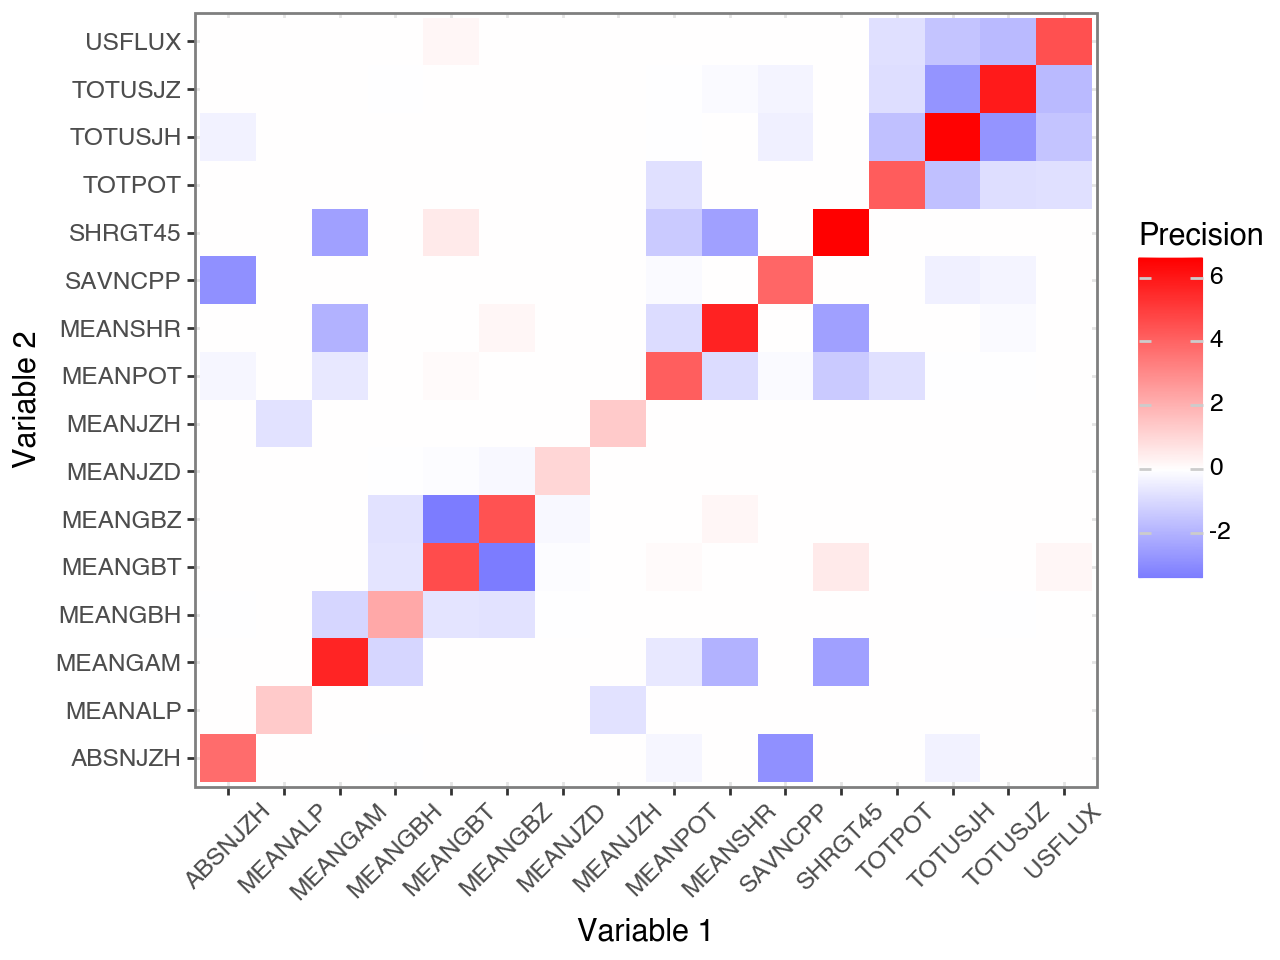

In [8]:
plot_precision_mat(precision_mat)

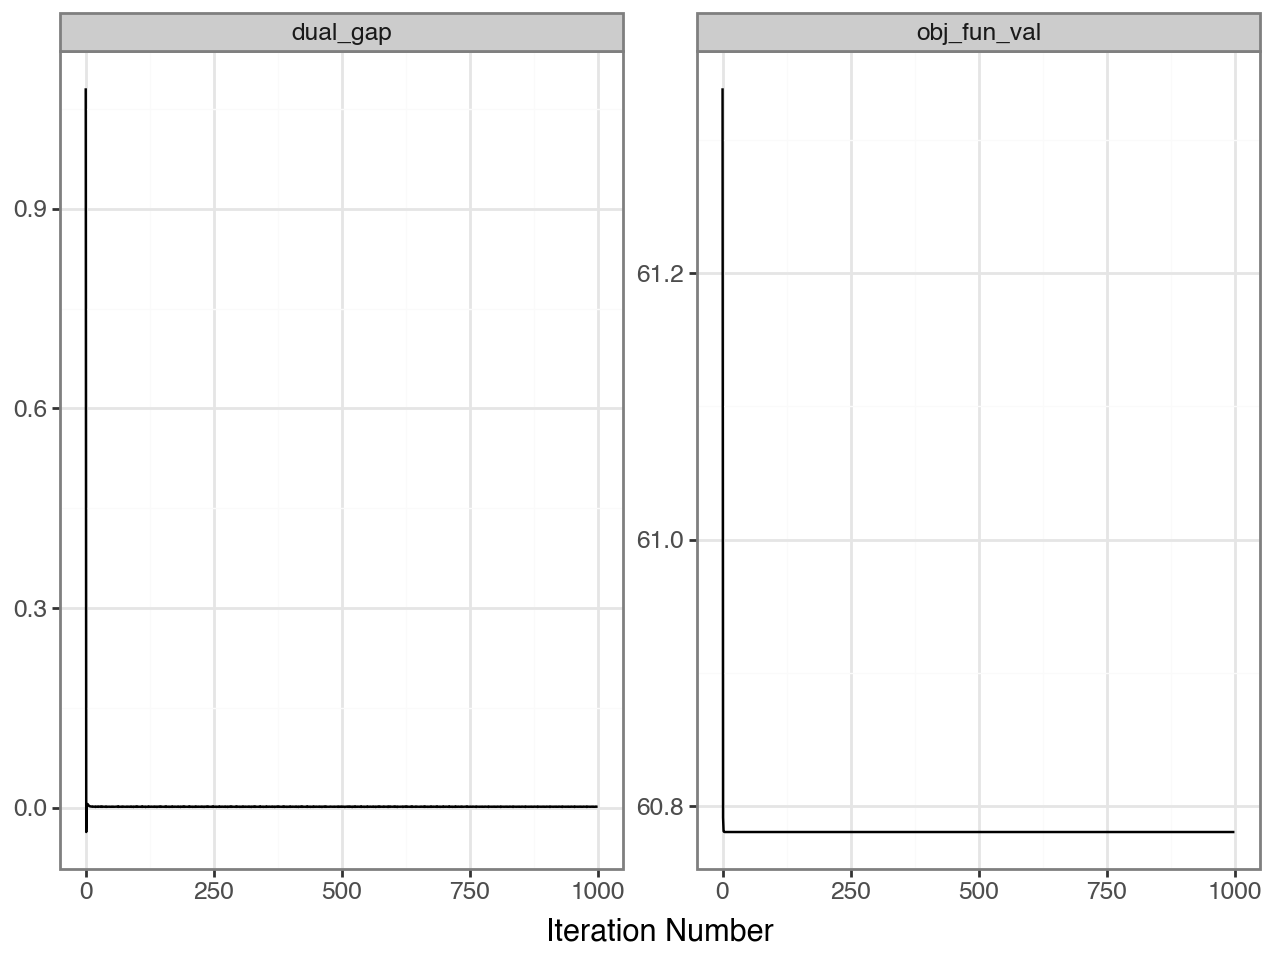

In [9]:
plot_costs(costs)

In [10]:
harp_data = harp_flare_data.loc[~harp_flare_data["are_any_sharp_params_na"] & ~harp_flare_data["was_during_flare"], sharp_params]
precision_mat, costs = run_graphical_lasso(harp_data, sharp_params)

/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.


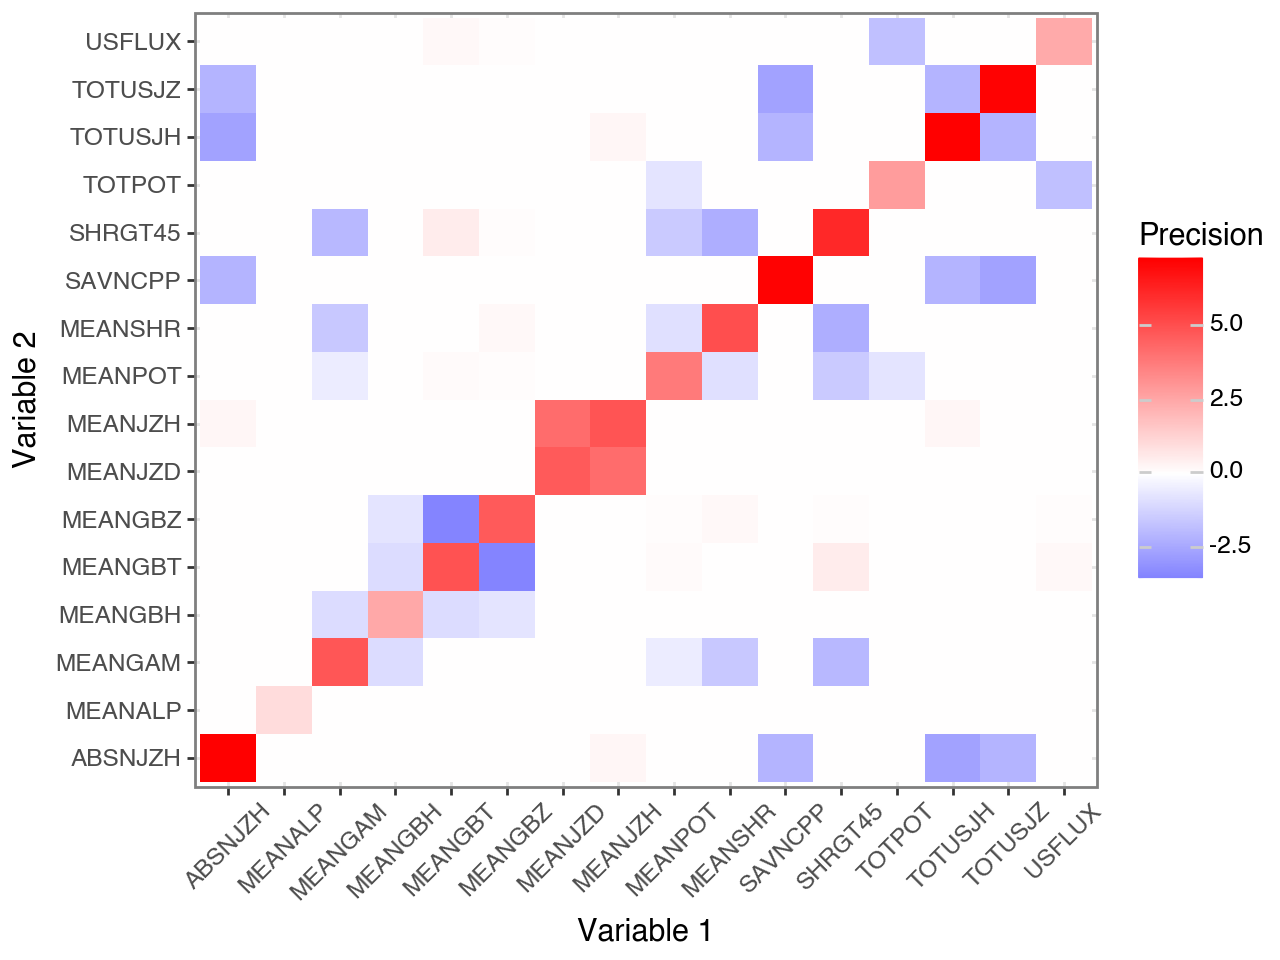

In [11]:
plot_precision_mat(precision_mat)

In [12]:
harp_stats = harp_flare_data.groupby("HARPNUM").size().reset_index(name="num_recs")

are_any_sharp_params_na = harp_flare_data[sharp_params].isna().any(axis=1)
harp_stats["sharp_params_na_prop"] = are_any_sharp_params_na.groupby(harp_flare_data["HARPNUM"]).mean().reset_index(drop=True)

are_any_areas_counts_na = harp_flare_data[areas_counts].isna().any(axis=1)
harp_stats["areas_counts_na_prop"] = are_any_areas_counts_na.groupby(harp_flare_data["HARPNUM"]).mean().reset_index(drop=True)

are_any_predictors_na = harp_flare_data[predictors].isna().any(axis=1)
harp_stats["predictors_na_prop"] = are_any_predictors_na.groupby(harp_flare_data["HARPNUM"]).mean().reset_index(drop=True)

was_during_flare = ~harp_flare_data["flare_class"].isna()
harp_stats["num_flare_recs"] = was_during_flare.groupby(harp_flare_data["HARPNUM"]).sum().reset_index(drop=True)

harp_stats.head()

,HARPNUM,num_recs,sharp_params_na_prop,areas_counts_na_prop,predictors_na_prop,num_flare_recs
0,1,1282,0.028861,0.027301,0.028861,5
1,2,541,0.070240,0.070240,0.070240,1
2,5,267,0.123596,0.123596,0.123596,5
3,6,524,0.047710,0.047710,0.047710,0
4,8,733,0.006821,0.006821,0.006821,26


In [13]:
harp_stats

,HARPNUM,num_recs,sharp_params_na_prop,areas_counts_na_prop,predictors_na_prop,num_flare_recs
0,1,1282,0.028861,0.027301,0.028861,5
1,2,541,0.070240,0.070240,0.070240,1
2,5,267,0.123596,0.123596,0.123596,5
3,6,524,0.047710,0.047710,0.047710,0
4,8,733,0.006821,0.006821,0.006821,26
...,...,...,...,...,...,...
6456,11564,182,0.615385,0.609890,0.615385,0
6457,11568,26,0.000000,0.000000,0.000000,0
6458,11569,344,0.122093,0.122093,0.122093,0
6459,11570,20,0.050000,0.050000,0.050000,0


In [152]:
has_no_nas = np.isclose(harp_stats["na_prop"], 0)
has_enough_recs = harp_stats["num_recs"] >= 500
harp_stats[has_no_nas & has_enough_recs]

,HARPNUM,num_recs,na_prop
178,317,598,0.0
190,335,901,0.0
208,361,688,0.0
326,589,535,0.0
374,662,1048,0.0
390,681,822,0.0
459,790,721,0.0
466,799,618,0.0
581,1016,1102,0.0
606,1064,1058,0.0


In [165]:
harp_num = 317
cols = sharp_params
harp_data = data[data["HARPNUM"] == harp_num][cols].to_numpy()

precision_mat, costs = run_graphical_lasso(harp_data, cols)

/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.527e-02


In [166]:
precision_mat

,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,SHRGT45
USFLUX,11.151880,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-1.775546,-0.072858,-0.602174,-3.774866,0.000000,0.000000,-0.283927,-4.670083,-0.000000,0.000000
MEANGAM,-0.000000,6.918816,0.051578,0.019773,-1.513435,-0.285112,-0.958413,-0.363508,-0.000000,-0.000000,-0.003051,0.000000,-0.000000,-0.371674,-1.798610,-2.534849
MEANGBT,-0.000000,0.051578,8.071744,-6.103866,-1.996732,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.761576,0.698984
MEANGBZ,-0.000000,0.019773,-6.103866,6.656297,-0.010594,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.072296,-0.061671,0.219866,0.000000,0.000000
MEANGBH,-0.000000,-1.513435,-1.996732,-0.010594,3.970283,-0.585568,-0.000000,-0.000000,0.000000,-0.739691,-0.039659,-0.000000,-0.898642,-0.000000,0.000000,0.000000
MEANJZD,-0.000000,-0.285112,0.000000,0.000000,-0.585568,1.582320,-0.000000,-0.000000,-0.000000,-0.000000,0.150606,-0.382367,0.769179,0.000000,0.467371,0.000000
TOTUSJZ,-1.775546,-0.958413,0.000000,0.000000,-0.000000,-0.000000,9.454260,-0.000000,-0.147663,-5.415288,-0.000000,-0.176354,-0.000000,-0.576698,-0.585932,-0.000000
MEANALP,-0.072858,-0.363508,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,7.974466,-5.871699,-0.000000,1.021730,0.046247,-0.000000,-0.000000,-0.370143,-0.286419
MEANJZH,-0.602174,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.147663,-5.871699,9.239938,-0.000000,2.607311,0.000000,-0.000000,-0.000000,-0.074229,-0.098928
TOTUSJH,-3.774866,-0.000000,-0.000000,-0.000000,-0.739691,-0.000000,-5.415288,-0.000000,-0.000000,12.451960,-0.000000,-0.000000,-0.355948,-2.298390,-0.000000,-0.000000


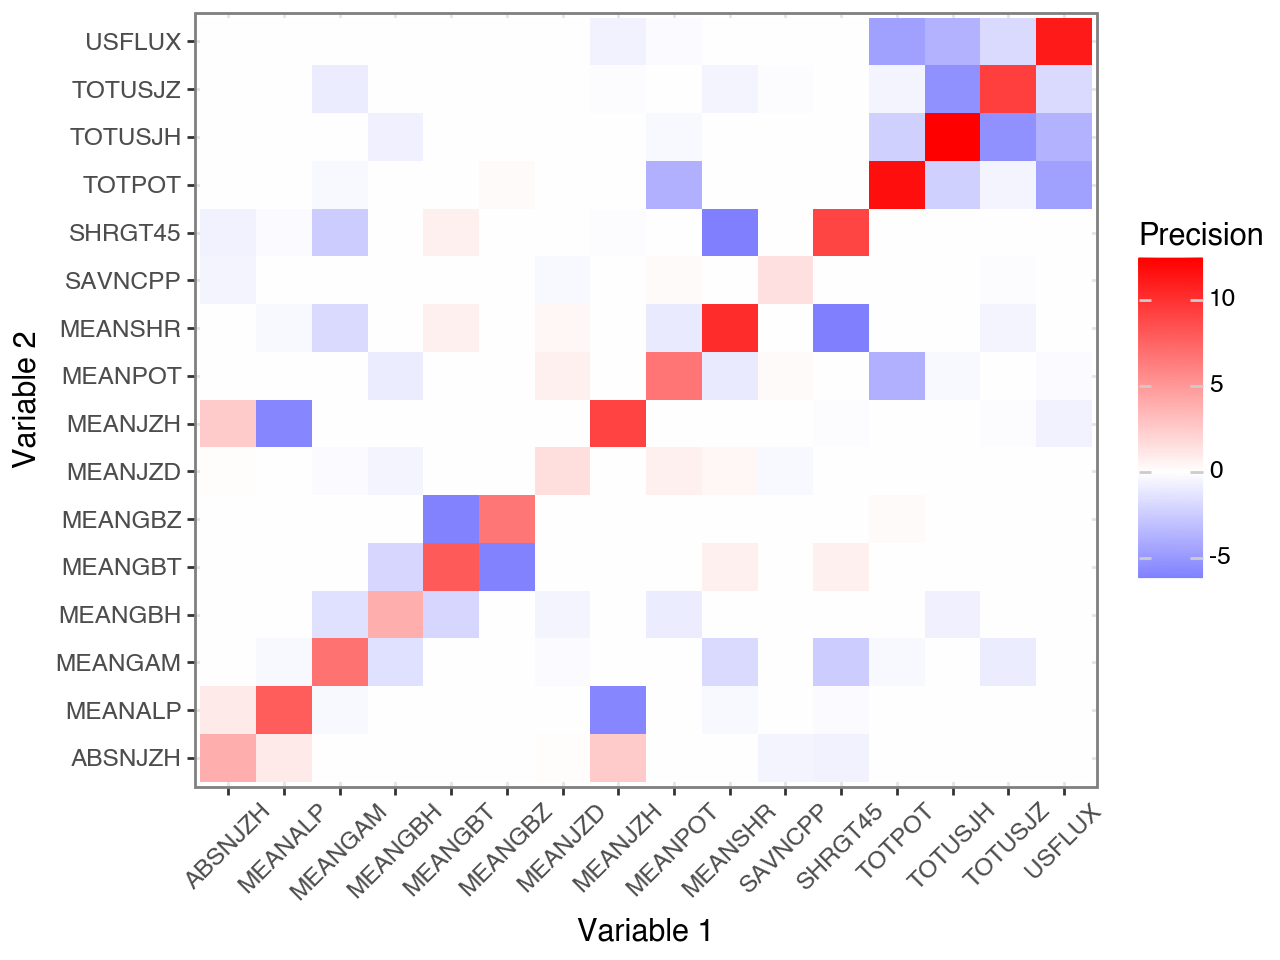

In [168]:
plot_precision_mat(precision_mat)

In [112]:
costs

,iter_num,obj_fun_val,dual_gap
0,0,55.239996,0.235584
1,1,53.539772,-0.074576
2,2,53.532056,-0.086350
3,3,53.528603,-0.067488
4,4,53.527066,-0.051370
...,...,...,...
995,995,53.525845,-0.025796
996,996,53.525864,-0.026355
997,997,53.525837,-0.025410
998,998,53.525842,-0.025666


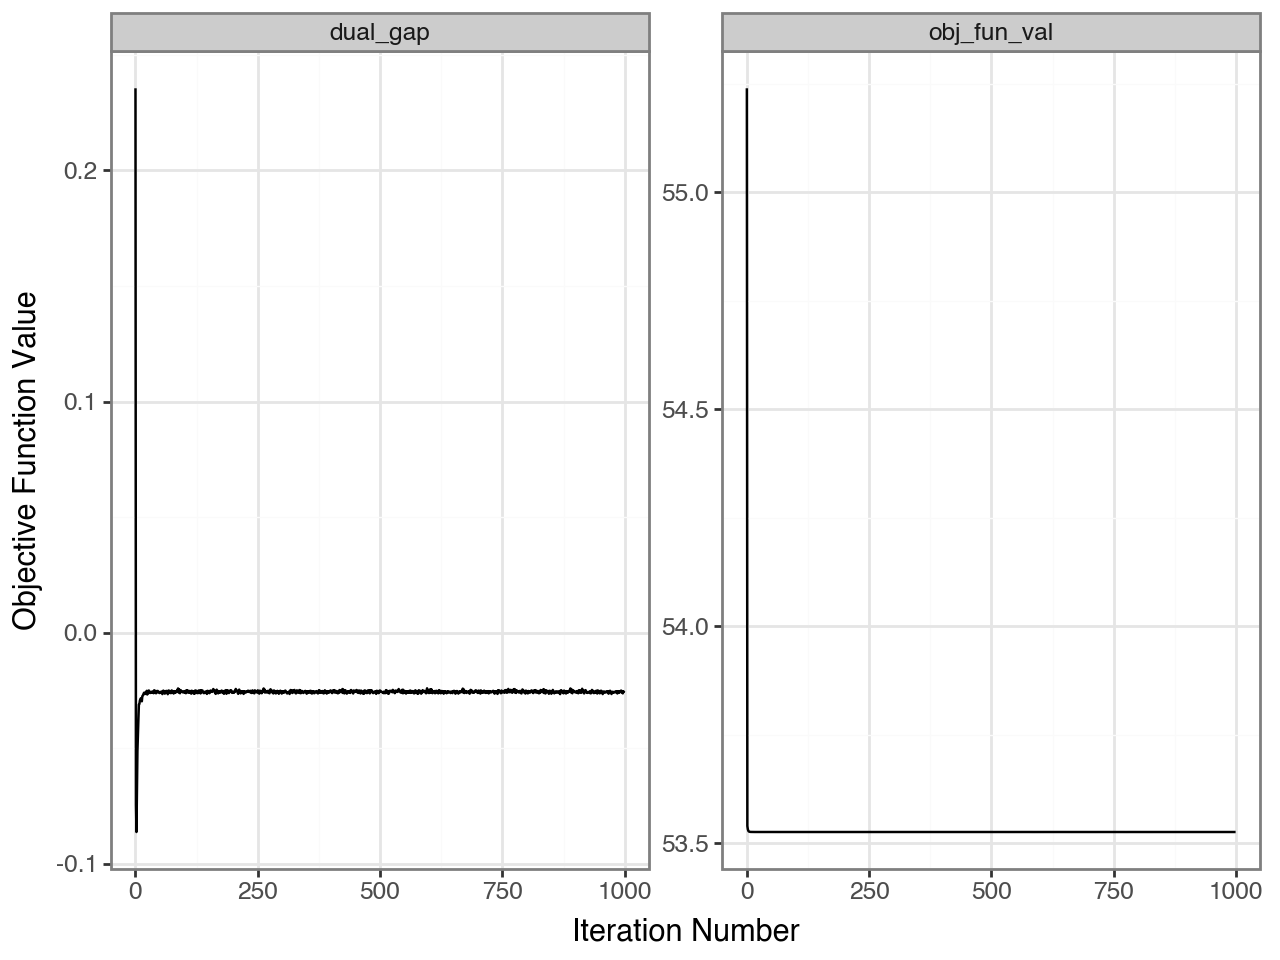

In [169]:
plot_costs(costs)